<a href="https://colab.research.google.com/github/pscabral/IFMASOFTEX_1/blob/main/mobilenetv2_4.00_160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
import gdown

# Especifique o ID do arquivo e o nome do arquivo de saída
file_id = '1aX48j7lKyE0c66tMZEesOwNncFbyvu6X'
output = 'dataset.zip'

# Baixe o arquivo do Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)
!unzip dataset.zip

In [14]:
import numpy as np
import pandas as pd
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2

from sklearn.metrics import classification_report, confusion_matrix

import os

import warnings
warnings.filterwarnings('ignore')

In [15]:
train_dir = "../content/dataset_3/train"
train_class=os.listdir(train_dir)
print(train_class)

val_dir = "../content/dataset_3/validation"
val_class=os.listdir(val_dir)
print(val_class)

test_dir = "../content/dataset_3/test"
test_class=os.listdir(test_dir)
print(test_class)

['grapes', 'garlic', 'lemon', 'pineapple', 'eggplant', 'chilli pepper', 'capsicum', 'watermelon', 'apple', 'turnip', 'spinach', 'onion', 'bell pepper', 'sweetcorn', 'cucumber', 'tomato', 'sweetpotato', 'cabbage', 'beetroot', 'corn', 'orange', 'potato', 'kiwi', 'soy beans', 'mango', 'lettuce', 'peas', 'cauliflower', 'banana', 'pear', 'carrot', 'ginger', 'paprika', 'raddish', 'jalepeno', 'pomegranate']
['grapes', 'garlic', 'lemon', 'pineapple', 'eggplant', 'chilli pepper', 'capsicum', 'watermelon', 'apple', 'turnip', 'spinach', 'onion', 'bell pepper', 'sweetcorn', 'cucumber', 'tomato', 'sweetpotato', 'cabbage', 'beetroot', 'corn', 'orange', 'potato', 'kiwi', 'soy beans', 'mango', 'lettuce', 'peas', 'cauliflower', 'banana', 'pear', 'carrot', 'ginger', 'paprika', 'raddish', 'jalepeno', 'pomegranate']
['grapes', 'garlic', 'lemon', 'pineapple', 'eggplant', 'chilli pepper', 'capsicum', 'watermelon', 'apple', 'turnip', 'spinach', 'onion', 'bell pepper', 'sweetcorn', 'cucumber', 'tomato', 'swee

In [16]:
x=[] # array value of the images
y=[] # the labels of the images

for folder in os.listdir(train_dir):
    image_list=os.listdir(train_dir+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(train_dir+"/"+folder+"/"+img_name,target_size=(224,224))
        img=image.img_to_array(img)

        # Transfer Learning: Preprocess of MobileNetV2 model to our images before passing it to MobileNetV2
        img=preprocess_input(img)

        x.append(img) # appending image array
        y.append(train_class.index(folder)) # appending class index to the array

print("Preparing Training Dataset Completed.")

Preparing Training Dataset Completed.


In [17]:
val_images=[]
val_images_Original=[]
val_image_label=[]

for folder in os.listdir(val_dir):
    image_list=os.listdir(val_dir+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(val_dir+"/"+folder+"/"+img_name,target_size=(224,224))

        # Converting to arrarys
        img=image.img_to_array(img)

        # Saving original images, will be used just for display at the end
        val_images_Original.append(img.copy())
        img=preprocess_input(img)

        # Appending arrays
        val_images.append(img)
        val_image_label.append(val_class.index(folder))

print("Preparing Validation Dataset Completed.")

Preparing Validation Dataset Completed.


In [18]:
test_images=[]
test_images_Original=[]
test_image_label=[]

for folder in os.listdir(test_dir):
    image_list=os.listdir(test_dir+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(test_dir+"/"+folder+"/"+img_name,target_size=(224,224))

        # Converting to arrarys
        img=image.img_to_array(img)

        # Saving original images, will be used just for display at the end
        test_images_Original.append(img.copy())
        img=preprocess_input(img)

        # Appending arrays
        test_images.append(img)
        test_image_label.append(test_class.index(folder))

print("Preparing Test Dataset Completed.")

Preparing Test Dataset Completed.


In [19]:
print("Training Dataset")

x=np.array(x) # Converting to np arrary to pass to the model
print(x.shape)

y=to_categorical(y) # onehot encoding of the labels
# print(y)
print(y.shape)

# Validation Dataset
print("Validation Dataset")

val_images=np.array(val_images)
print(val_images.shape)

val_image_label=to_categorical(val_image_label) # onehot encoding of the labels)
print(val_image_label.shape)

print("Test Dataset")

test_images=np.array(test_images)
print(test_images.shape)

test_image_label=to_categorical(test_image_label) # onehot encoding of the labels)
print(test_image_label.shape)

Training Dataset
(3115, 224, 224, 3)
(3115, 36)
Validation Dataset
(351, 224, 224, 3)
(351, 36)
Test Dataset
(359, 224, 224, 3)
(359, 36)


In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=5)
print("Splitting data for train and test completed.")

Splitting data for train and test completed.


In [21]:
rand_images1 = random.sample(os.listdir("../content/dataset_3/train/orange"), 8)
rand_images2 = random.sample(os.listdir("../content/dataset_3/train/apple"), 8)

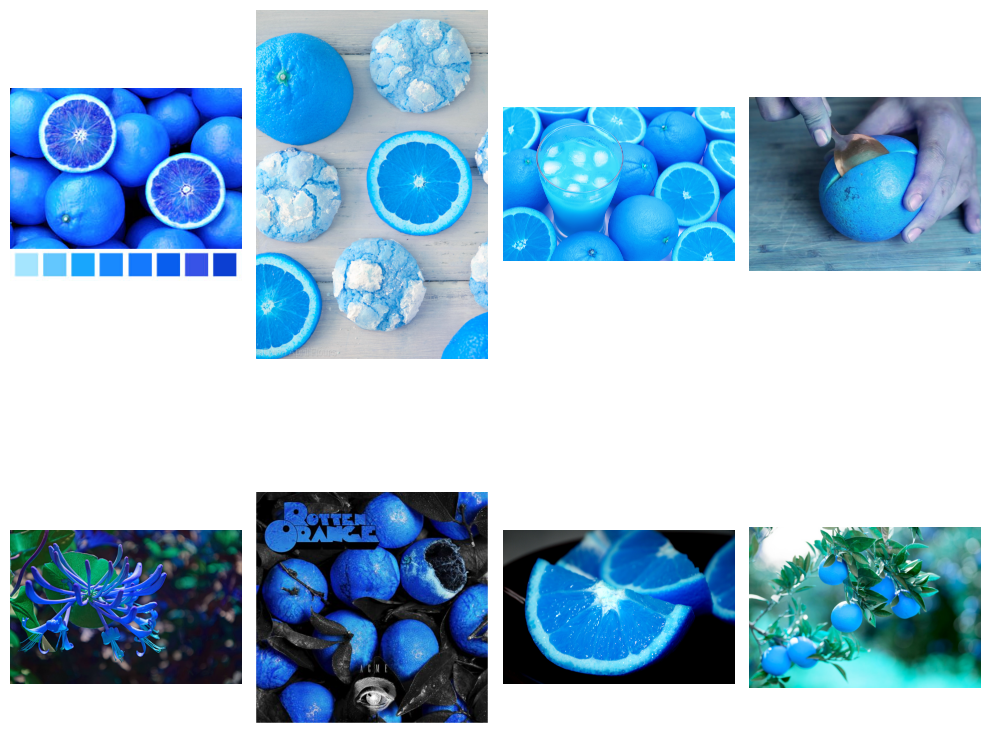

In [22]:
fig = plt.figure(figsize=(10,10))
for i, im in enumerate(rand_images1):
    plt.subplot(2,4 , i+1)
    im = cv2.imread(os.path.join("../content/dataset_3/train/orange", im))
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.show()

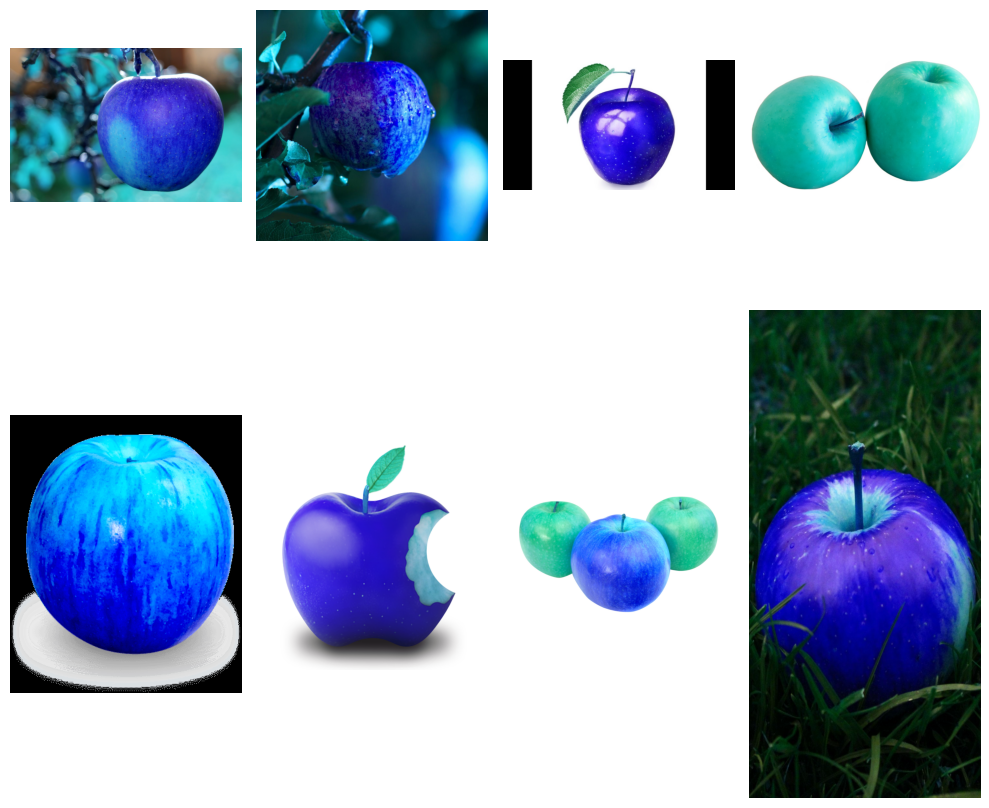

In [23]:
fig = plt.figure(figsize=(10,10))
for i, im in enumerate(rand_images2):
    plt.subplot(2,4 , i+1)
    im = cv2.imread(os.path.join("../content/dataset_3/train/apple", im))
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(224,224,3))

In [25]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model with pre-trained weights
mnet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Then define your Sequential model using mnet as a base
model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation="relu"),
                    Dropout(0.1),
                    Dense(36, activation="softmax")])

model.layers[0].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                      

In [26]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [27]:
EPOCHS = 20
hist = model.fit(xtrain, ytrain, epochs=EPOCHS, callbacks=[lr_callbacks], validation_data=(xtest,ytest))

Epoch 1/20
78/78 [==============================] - 111s 1s/step - loss: 1.6170 - accuracy: 0.5738 - val_loss: 0.9907 - val_accuracy: 0.6918 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 119s 2s/step - loss: 0.5435 - accuracy: 0.8407 - val_loss: 0.7331 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 99s 1s/step - loss: 0.3323 - accuracy: 0.8957 - val_loss: 0.7442 - val_accuracy: 0.7640 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - 94s 1s/step - loss: 0.2019 - accuracy: 0.9414 - val_loss: 0.6660 - val_accuracy: 0.7737 - lr: 1.0000e-04
Epoch 5/20
78/78 [==============================] - 95s 1s/step - loss: 0.1618 - accuracy: 0.9607 - val_loss: 0.6472 - val_accuracy: 0.7801 - lr: 1.0000e-04
Epoch 6/20
78/78 [==============================] - 100s 1s/step - loss: 0.1420 - accuracy: 0.9655 - val_loss: 0.6392 - val_accuracy: 0.7801 - lr: 1.0000e-04
Epoch 7/20
78/78 [==============================] - 96s 1s/step - l

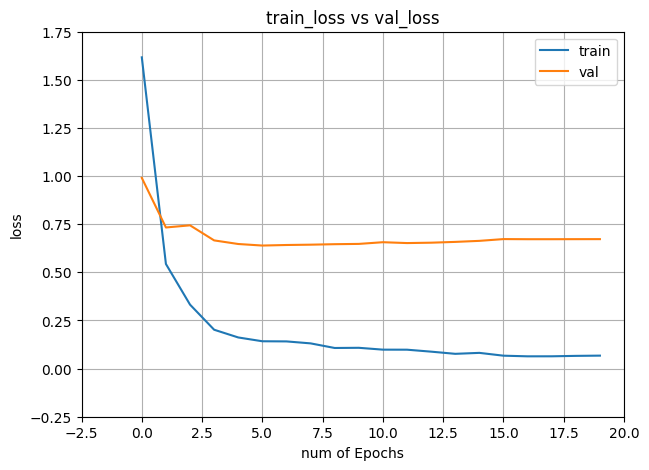

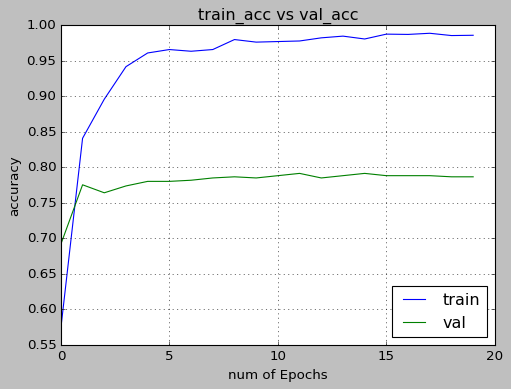

In [28]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [29]:
def predict(img_name, model):
    img=image.load_img(img_name,target_size=(224,224))
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img=preprocess_input(img)
    prediction=model.predict(img.reshape(1,224,224,3))
    output=np.argmax(prediction)
    print(train_class[output])


# This function plots the image supplied in array
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.astype('int32'))
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

In [30]:
predictions=[]

for img in test_images:
    img=img.reshape(1,224,224,3)
    predictions.append(model.predict(img))

1/1 [==============================] - 0s 53ms/step


In [31]:
pred_labels = model.predict(test_images)

12/12 [==============================] - 13s 1s/step


In [32]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_image_label, pred_labels, target_names=test_class))

               precision    recall  f1-score   support

       grapes       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
        lemon       1.00      1.00      1.00        10
    pineapple       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
chilli pepper       0.83      1.00      0.91        10
     capsicum       0.90      0.90      0.90        10
   watermelon       1.00      1.00      1.00        10
        apple       0.78      0.70      0.74        10
       turnip       1.00      1.00      1.00        10
      spinach       1.00      1.00      1.00        10
        onion       1.00      1.00      1.00        10
  bell pepper       0.90      0.90      0.90        10
    sweetcorn       0.90      0.90      0.90        10
     cucumber       1.00      1.00      1.00        10
       tomato       1.00      1.00      1.00        10
  sweetpotato       1.00      1.00      1.00        10
      cab

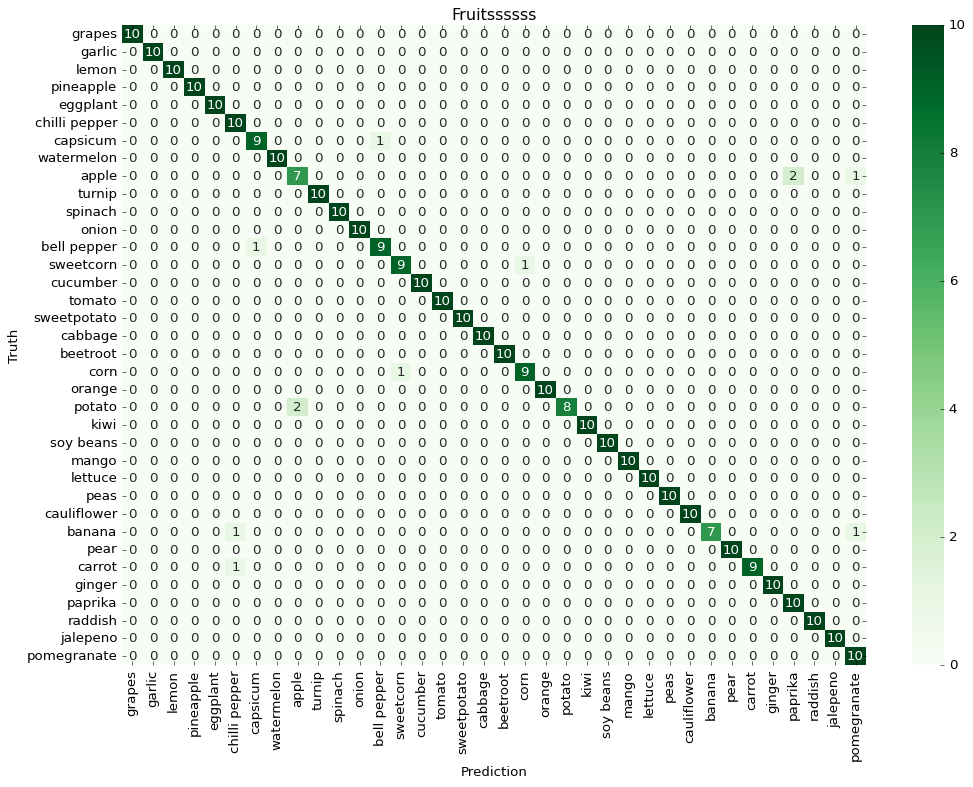

In [38]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_image_label, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= test_class,
                yticklabels=test_class)

plt.title('Fruitssssss')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

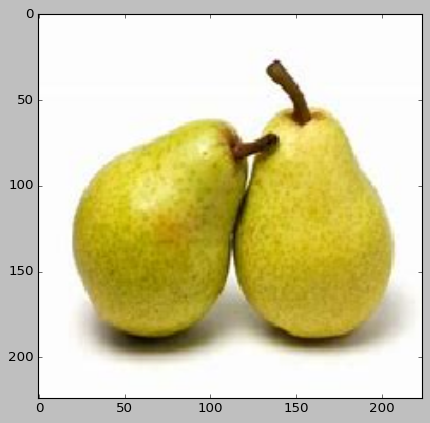

1/1 [==============================] - 0s 90ms/step
pear


In [59]:
predict("../content/pera03.jpg",model)

In [65]:
pip install pytesseract gTTS
import pytesseract
from PIL import Image
from gtts import gTTS
import os

# Função para realizar a previsão do conteúdo da imagem
def predict(image_path, model):
    try:
        # Carrega a imagem
        img = Image.open(image_path)

        # Realiza o reconhecimento de texto na imagem usando o Tesseract
        text = pytesseract.image_to_string(img)

        # Fala o resultado usando o gTTS
        tts = gTTS(text)
        tts.save("result.mp3")
        os.system("mpg321 result.mp3")  # Este comando executa a fala (certifique-se de ter o mpg321 instalado)

    except Exception as e:
        print(f"Erro ao prever a imagem: {e}")

# Exemplo de uso
image_path = "../content/pera03.jpg"
model = "seu_modelo_aqui"  # Substitua "seu_modelo_aqui" pelo caminho do seu modelo
predict(image_path, model)


Erro ao prever a imagem: tesseract is not installed or it's not in your PATH. See README file for more information.
